<a href="https://colab.research.google.com/github/sidh26/ANN/blob/main/classwork/ANN%2013th%20Mar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

LSTM takes 3D input  
(batch_size, seq_len, num_features)

batch size: number of observations  
seq_len is number of historical observations in 1 observation  
features is number of features in each observation

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [ ]:
flight_data = sns.load_dataset('flights')
flight_data.head()

(   year month  passengers
 0  1949   Jan         112
 1  1949   Feb         118
 2  1949   Mar         132
 3  1949   Apr         129
 4  1949   May         121, (144, 3))

In [ ]:
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams['figure.figsize'] = fig_size

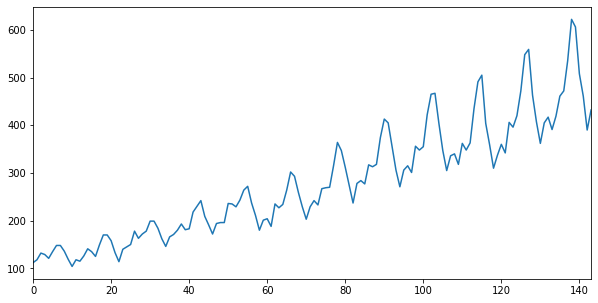

In [ ]:
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])

In [ ]:
data = flight_data['passengers'].values.astype(float)
data

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [ ]:
test_size=12

train_data = data[:-test_size]
test_data = data[-test_size:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_norm = scaler.fit_transform(train_data.reshape(-1,1))

In [ ]:
train_data_norm = torch.FloatTensor(train_data_norm).view(-1)
train_data_norm.shape

torch.Size([132])

In [ ]:
def convert2matrix(data_arr, look_back):
    # X, Y = [], []
    inout_seq = []
    for i in range(len(data_arr)-look_back):
        d = i+look_back
        X = data_arr[i:d]
        Y = data_arr[d]
        inout_seq.append((X, Y))
    return inout_seq

In [ ]:
train_inout_seq = convert2matrix(train_data_norm, look_back = 4)
train_inout_seq[:5]

[(tensor([-0.9648, -0.9385, -0.8769, -0.8901]), tensor(-0.9253)),
 (tensor([-0.9385, -0.8769, -0.8901, -0.9253]), tensor(-0.8637)),
 (tensor([-0.8769, -0.8901, -0.9253, -0.8637]), tensor(-0.8066)),
 (tensor([-0.8901, -0.9253, -0.8637, -0.8066]), tensor(-0.8066)),
 (tensor([-0.9253, -0.8637, -0.8066, -0.8066]), tensor(-0.8593))]

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_classes=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

    def forward(self, X):
        # print(X.view(len(X), 1, -1))
        lstm_out, self.hidden_cell = self.lstm(X.view(len(X), 1, -1), self.hidden_cell)
        predictions = self.fc(lstm_out.view(len(X), -1))

        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 150 
for i in range(epochs): 
    for seq, labels in train_inout_seq: 
        optimizer.zero_grad() 
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_size), torch.zeros(1, 1, model.hidden_size)) 
        y_pred = model(seq) 
        single_loss = loss_function(y_pred, labels) 
        single_loss.backward() 
        optimizer.step() 
    if i%25 == 1: 
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}') 
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.01185603
epoch:  26 loss: 0.00106848
epoch:  51 loss: 0.00031955
epoch:  76 loss: 0.00092063
epoch: 101 loss: 0.00043937
epoch: 126 loss: 0.00014478
epoch: 149 loss: 0.0004232541


In [ ]:
labels

tensor(0.3231)

In [ ]:
y_pred

tensor([0.3025], grad_fn=<SelectBackward>)

# Stock Data

In [ ]:
stock = pd.read_csv('stock.csv')
data = stock[['Average', 'Volume', 'Close']]
data['Volume'].astype(float)
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Average,Volume,Close
0,226.70,6449426.0,227.80
1,223.50,14092071.0,220.70
2,219.90,15074848.0,217.75
3,218.15,11921123.0,216.85
4,211.55,14342279.0,209.55


In [ ]:
stock = pd.read_csv('stock.csv')
data = stock[['Average', 'Volume', 'Close']]
data['Volume'] = data['Volume'].astype()

NameError: ignored

In [ ]:
data.head()

,Average,Volume,Close
0,226.70,6449426.0,227.80
1,223.50,14092071.0,220.70
2,219.90,15074848.0,217.75
3,218.15,11921123.0,216.85
4,211.55,14342279.0,209.55


In [ ]:
test_size=30

train_data = data[:-test_size]
test_data = data[-test_size:]

In [ ]:
train_data

,Average,Volume,Close
0,226.700,6449426.0,227.80
1,223.500,14092071.0,220.70
2,219.900,15074848.0,217.75
3,218.150,11921123.0,216.85
4,211.550,14342279.0,209.55
...,...,...,...
460,324.000,82984969.0,333.55
461,337.275,38777555.0,331.05
462,331.100,25647162.0,329.10
463,326.700,17389606.0,324.95


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
train_data_norm = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data_norm = pd.DataFrame(scaler.transform(test_data), columns=train_data.columns)

In [ ]:
train_data_norm

,Average,Volume,Close
0,-0.199783,-0.966676,-0.163686
1,-0.234504,-0.908015,-0.241816
2,-0.273566,-0.900472,-0.274278
3,-0.292554,-0.924678,-0.284182
4,-0.364167,-0.906095,-0.364512
...,...,...,...
460,0.855961,-0.379228,1.000000
461,1.000000,-0.718542,0.972490
462,0.932999,-0.819324,0.951032
463,0.885257,-0.882705,0.905365


In [ ]:
def create_inout_seq(data_arr, look_back):
    inout_seq = []
    for i in range(len(data_arr)-look_back):
        d = i+look_back
        X = data_arr[i:d]
        Y = data_arr['Close'][d]
        inout_seq.append((X, Y))
    return inout_seq

In [ ]:
train_inout_seq = create_inout_seq(train_data_norm, 5)

In [ ]:
train_inout_seq

[(    Average    Volume     Close
  0 -0.199783 -0.966676 -0.163686
  1 -0.234504 -0.908015 -0.241816
  2 -0.273566 -0.900472 -0.274278
  3 -0.292554 -0.924678 -0.284182
  4 -0.364167 -0.906095 -0.364512, -0.37111416781293016),
 (    Average    Volume     Close
  1 -0.234504 -0.908015 -0.241816
  2 -0.273566 -0.900472 -0.274278
  3 -0.292554 -0.924678 -0.284182
  4 -0.364167 -0.906095 -0.364512
  5 -0.375017 -0.926024 -0.371114, -0.42228335625859703),
 (    Average    Volume     Close
  2 -0.273566 -0.900472 -0.274278
  3 -0.292554 -0.924678 -0.284182
  4 -0.364167 -0.906095 -0.364512
  5 -0.375017 -0.926024 -0.371114
  6 -0.434423 -0.868135 -0.422283, -0.4762035763411281),
 (    Average    Volume     Close
  3 -0.292554 -0.924678 -0.284182
  4 -0.364167 -0.906095 -0.364512
  5 -0.375017 -0.926024 -0.371114
  6 -0.434423 -0.868135 -0.422283
  7 -0.469958 -0.860222 -0.476204, -0.4596973865199452),
 (    Average    Volume     Close
  4 -0.364167 -0.906095 -0.364512
  5 -0.375017 -0.92602

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=100, num_classes=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, num_classes)

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

    def forward(self, X):
        lstm_out, self.hidden_cell = self.lstm(X.view(len(X), 1, -1), self.hidden_cell)
        predictions = self.fc(lstm_out.view(len(X), -1))

        return predictions[-1]

In [ ]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 150 
for i in range(epochs): 
    for seq, labels in train_inout_seq: 
        optimizer.zero_grad() 
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_size), torch.zeros(1, 1, model.hidden_size)) 
        y_pred = model(torch.tensor(seq.values).double()) 
        single_loss = loss_function(y_pred, labels) 
        single_loss.backward() 
        optimizer.step() 
    if i%25 == 1: 
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}') 
print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

RuntimeError: ignored

In [ ]:
torch.tensor(seq.values)

tensor([[-0.1998, -0.9667, -0.1637],
        [-0.2345, -0.9080, -0.2418],
        [-0.2736, -0.9005, -0.2743],
        [-0.2926, -0.9247, -0.2842],
        [-0.3642, -0.9061, -0.3645]], dtype=torch.float64)

In [ ]:
t = torch.tensor(seq.values)

In [ ]:
t.type(torch.DoubleTensor)

tensor([[-0.1998, -0.9667, -0.1637],
        [-0.2345, -0.9080, -0.2418],
        [-0.2736, -0.9005, -0.2743],
        [-0.2926, -0.9247, -0.2842],
        [-0.3642, -0.9061, -0.3645]], dtype=torch.float64)